In [16]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 1. Import the Data

In [17]:
trans = pd.read_csv("product_category_name_translation.csv")
oo = pd.read_csv("olist_orders_dataset.csv")
ooi = pd.read_csv("olist_order_items_dataset.csv")
oop = pd.read_csv("olist_order_payments_dataset.csv")
oor = pd.read_csv("olist_order_reviews_dataset.csv")
oc = pd.read_csv("olist_customers_dataset.csv")
og = pd.read_csv("olist_geolocation_dataset.csv")
op = pd.read_csv("olist_products_dataset.csv")
os = pd.read_csv("olist_sellers_dataset.csv")

# 2. Clean the Data

## 2.1. Order Data

In [18]:
oo.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [19]:
oo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


### 2.1.1. Convert all columns to suitable type

In [20]:
oo['order_purchase_timestamp']= oo['order_purchase_timestamp'].astype('datetime64[ns]')
oo['order_approved_at'] = oo['order_approved_at'].astype('datetime64[ns]')
oo['order_delivered_carrier_date'] = oo['order_delivered_carrier_date'].astype('datetime64[ns]')
oo['order_delivered_customer_date'] = oo['order_delivered_customer_date'].astype('datetime64[ns]')
oo['order_estimated_delivery_date'] = oo['order_estimated_delivery_date'].astype('datetime64[ns]')

### 2.1.2. Check for Null Value

In [21]:
oo.isnull().sum()                                  

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

##### There are 3 columns with missing values, all in datetime type, so I decided to fill them with the value from their above row. However, to ensure that the filled date is not less than the date appearing in the previous column (order_delivered_carrier_date < order_approved_at, for instance), I set the condition that if the filled date is lower, it will be filled with the data from the left column and plus 1 day

In [22]:
oo['order_approved_at'] = oo['order_approved_at'].ffill()
oo['order_approved_at'] = np.where(oo['order_approved_at'] < oo['order_purchase_timestamp'],
                                oo['order_purchase_timestamp'] + pd.DateOffset(days=1),
                                oo['order_approved_at'] + pd.DateOffset(days=0))

oo['order_delivered_carrier_date'] = oo['order_delivered_carrier_date'].ffill()
oo['order_delivered_carrier_date'] = np.where(oo['order_delivered_carrier_date'] < oo['order_approved_at'],
                                oo['order_approved_at'] + pd.DateOffset(days=1),
                                oo['order_delivered_carrier_date'] + pd.DateOffset(days=0))

oo['order_delivered_customer_date'] = oo['order_delivered_customer_date'].ffill()
oo['order_delivered_customer_date'] = np.where(oo['order_delivered_customer_date'] < oo['order_delivered_carrier_date'],
                                oo['order_delivered_carrier_date'] + pd.DateOffset(days=1),
                                oo['order_delivered_customer_date'] + pd.DateOffset(days=0))

### 2.1.3. Check for Duplicated Value

In [23]:
oo.duplicated().sum()

0

### 2.1.4. Check if there is any mispell word in 'order_status' column

In [24]:
oo['order_status'].unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

## 2.2. Oder Items Data

In [25]:
ooi.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [26]:
ooi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


##### So there is no null value at all

### 2.2.1. Check for Duplicated Value

In [27]:
ooi.duplicated().sum()

0

### 2.2.2. Convert all columns to suitable type

In [28]:
ooi['shipping_limit_date'] = ooi['shipping_limit_date'].astype('datetime64[ns]')

## 2.3. Order Reviews Data

In [29]:
oor.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


oor.info()

### 2.3.1. Check for Null value

In [30]:
oor.isnull().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [31]:
oor = oor.drop (["review_comment_title", "review_comment_message"], axis = 1)

### 2.3.2. Check for Duplicated Value

In [32]:
oor.duplicated().sum()

0

### 2.3.3. Convert all columns to suitable type

In [33]:
oor['review_creation_date']= oor['review_creation_date'].astype('datetime64[ns]')
oor['review_answer_timestamp']= oor['review_answer_timestamp'].astype('datetime64[ns]')

## 2.4. Order Payment Data

In [34]:
oop.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [35]:
oop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


### 2.4.1. Check for Duplicated Value

In [36]:
oop.duplicated().sum()

0

### 2.4.2. Check if there is any mispell word in 'payment_type' column

In [37]:
oop['payment_type'] = oop['payment_type'].str.replace('_',' ')
oop['payment_type'] = oop['payment_type'].str.title()
oop['payment_type'].unique()

array(['Credit Card', 'Boleto', 'Voucher', 'Debit Card', 'Not Defined'],
      dtype=object)

## 2.5. Geolocation Data

In [38]:
og.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [39]:
og.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


##### From the Info, there is no Null Value

### 2.5.1. Check for Duplicated Value

In [40]:
og.duplicated().sum()

261831

In [41]:
og[og.duplicated()]

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
15,1046,-23.546081,-46.644820,sao paulo,SP
44,1046,-23.546081,-46.644820,sao paulo,SP
65,1046,-23.546081,-46.644820,sao paulo,SP
66,1009,-23.546935,-46.636588,sao paulo,SP
67,1046,-23.546081,-46.644820,sao paulo,SP
...,...,...,...,...,...
1000153,99970,-28.343273,-51.873734,ciriaco,RS
1000154,99950,-28.070493,-52.011342,tapejara,RS
1000159,99900,-27.877125,-52.224882,getulio vargas,RS
1000160,99950,-28.071855,-52.014716,tapejara,RS


In [42]:
og = og.drop_duplicates()

In [43]:
og.shape

(738332, 5)

##### The number of row reduce from over 1.000.000 at the begining to 738.332 now

### 2.5.2. Check if there is any mispell word in 'geolocation_city' column

In [44]:
og['geolocation_city'].unique()

array(['sao paulo', 'são paulo', 'sao bernardo do campo', ..., 'ciríaco',
       'estação', 'vila lângaro'], dtype=object)

In [45]:
og['geolocation_city'].nunique()

8011

##### It can be clearly seen that the data has some special characters and mispelled words, and there are over 8.000 different cities in the data

In [46]:
from unidecode import unidecode
og.loc[:,'geolocation_city'] = og['geolocation_city'].apply(lambda x: unidecode(x))                  # Transform local writing into international one(from 'são' to 'sao') 
og.loc[:,'geolocation_city'] = og['geolocation_city'].apply(lambda x: re.sub(r'[^\w\s]', '', x))     # Remove special character like $, %
og.loc[:,'geolocation_city'] = og['geolocation_city'].str.replace(' ','')                            # Remove spacing
og.loc[:,'geolocation_city'] = og['geolocation_city'].str.lower()                                    # Lower Case all the data
og.loc[:,'code'] = og['geolocation_city'] + og['geolocation_state']                                  # Cuz states may have similar city name, so i create a code include city name and state
og['geolocation_city'].nunique()

5901

##### After some adjustment, he number of unique city reduce from over 8.001 to 5.901. What I need to do now is to 
##### - Find the standard version of these city name
##### - Find the state name for each state code
##### To have the city name, I've found a data of standard city name of Brazil on Kaggle. Cuz there are many state that have the same city name, so i create a column named 'code', which is the combination of city name and state. I also do so to the table on Kaggle, so that i can latter merge these 2 tables and get the right name for each code matched

In [47]:
br = pd.read_csv("BRAZIL_CITIES_REV2022.csv")
br = br.iloc[:, [0,1]]

br['city'] = br['CITY'].apply(lambda x: unidecode(x))
br['city'] = br['city'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
br['city'] = br['city'].str.replace(' ','')
br['city'] = br['city'].str.lower()
br = br.drop_duplicates()
br['code'] = br['city'] + br['STATE']
br.head()

,CITY,STATE,city,code
0,Abadia De Goiás,GO,abadiadegoias,abadiadegoiasGO
1,Abadia Dos Dourados,MG,abadiadosdourados,abadiadosdouradosMG
2,Abadiânia,GO,abadiania,abadianiaGO
3,Abaetetuba,PA,abaetetuba,abaetetubaPA
4,Abaeté,MG,abaete,abaeteMG


##### After Having the right city name, I also found a table from wiki that contain state code and state name as well

In [48]:
url = "https://en.wikipedia.org/wiki/ISO_3166-2:BR" 

tables = pd.read_html(url)

print(f"Number of tables found: {len(tables)}")
state_code = tables[0] 
state_code = state_code.iloc[:, [0,1]]
state_code.loc[:,'Code'] = state_code['Code'].str[-2:]
state_code.head()

Number of tables found: 4


,Code,Subdivision name (pt)
0,AC,Acre
1,AL,Alagoas
2,AP,Amapá
3,AM,Amazonas
4,BA,Bahia


In [49]:
og = pd.merge(og, br[['code','CITY']], on='code', how='left')
og.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,code,CITY
0,1037,-23.545621,-46.639292,saopaulo,SP,saopauloSP,São Paulo
1,1046,-23.546081,-46.644820,saopaulo,SP,saopauloSP,São Paulo
2,1046,-23.546129,-46.642951,saopaulo,SP,saopauloSP,São Paulo
3,1041,-23.544392,-46.639499,saopaulo,SP,saopauloSP,São Paulo
4,1035,-23.541578,-46.641607,saopaulo,SP,saopauloSP,São Paulo


In [50]:
og.isnull().sum()

geolocation_zip_code_prefix       0
geolocation_lat                   0
geolocation_lng                   0
geolocation_city                  0
geolocation_state                 0
code                              0
CITY                           3999
dtype: int64

##### After merging, most of the data found their right city name. However, there are still 3.999 out of 738.332 haven't found their right name. Also mean only 0.541% of the data is not correct, but this number is too minor so I gonna handle it if I have free time

In [36]:
null = og[og['CITY'].isnull()]
null['code'].value_counts().reset_index().head(10)

,code,count
0,embuSP,285
1,paratiRJ,153
2,piumhiiMG,98
3,barradesaojoaoRJ,71
4,bonfimpaulistaSP,69
5,cachoeiradocampoMG,62
6,arraialdajudaBA,61
7,taguatingaDF,59
8,papucaiaRJ,53
9,bomjesusGO,53


In [37]:
br[br['city'].str.contains('tagua')]

,CITY,STATE,city,code
524,Bataguassu,MS,bataguassu,bataguassuMS
1132,Cataguases,MG,cataguases,cataguasesMG
2271,Itaguajé,PR,itaguaje,itaguajePR
2272,Itaguara,MG,itaguara,itaguaraMG
2273,Itaguari,GO,itaguari,itaguariGO
2274,Itaguaru,GO,itaguaru,itaguaruGO
2275,Itaguatins,TO,itaguatins,itaguatinsTO
2276,Itaguaçu,ES,itaguacu,itaguacuES
2277,Itaguaçu Da Bahia,BA,itaguacudabahia,itaguacudabahiaBA
2278,Itaguaí,RJ,itaguai,itaguaiRJ


In [38]:
for i, data in og['code'].items():
    if data == 'embuSP':
        og.loc[i, 'code'] = 'embudasartesSP'         # Embu is a short-hand version of embudasartes
    if data == 'paratiRJ':
        og.loc[i, 'code'] = 'paratyRJ'               # Just a mispelled
    if data == 'piumhiiMG':
        og.loc[i, 'code'] = 'piumhiMG'               # Just a mispelled
    if data == 'barradesaojoaoRJ':
        og.loc[i, 'code'] = 'saojoaodabarraRJ'       # It is written backwards
    if data == 'bonfimpaulistaSP':
        og.loc[i, 'code'] = 'ribeiraopretoSP'        # It a district of Ribeirão Preto
    if data == 'cachoeiradocampoMG':
        og.loc[i, 'code'] = 'ouropretoMG'            # It a district of Ouro Preto
    if data == 'arraialdajudaBA':
        og.loc[i, 'code'] = 'portoseguroBA'          # It a district of Porto Seguro
         

##### Now I just need to replace the messy city name and coded state with their right name

In [51]:
og = pd.merge(og, state_code, left_on='geolocation_state', right_on='Code', how='left')
og.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,code,CITY,Code,Subdivision name (pt)
0,1037,-23.545621,-46.639292,saopaulo,SP,saopauloSP,São Paulo,SP,São Paulo
1,1046,-23.546081,-46.644820,saopaulo,SP,saopauloSP,São Paulo,SP,São Paulo
2,1046,-23.546129,-46.642951,saopaulo,SP,saopauloSP,São Paulo,SP,São Paulo
3,1041,-23.544392,-46.639499,saopaulo,SP,saopauloSP,São Paulo,SP,São Paulo
4,1035,-23.541578,-46.641607,saopaulo,SP,saopauloSP,São Paulo,SP,São Paulo


In [52]:
og = og.drop(['geolocation_city', 'geolocation_state', 'code', 'Code'], axis = 1)
og = og.rename(columns = {'Subdivision name (pt)' : 'state','CITY' : 'city'})
og.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,city,state
0,1037,-23.545621,-46.639292,São Paulo,São Paulo
1,1046,-23.546081,-46.644820,São Paulo,São Paulo
2,1046,-23.546129,-46.642951,São Paulo,São Paulo
3,1041,-23.544392,-46.639499,São Paulo,São Paulo
4,1035,-23.541578,-46.641607,São Paulo,São Paulo


In [53]:
og['city'] = og['city'].fillna('Other')

In [54]:
og.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 738332 entries, 0 to 738331
Data columns (total 5 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   geolocation_zip_code_prefix  738332 non-null  int64  
 1   geolocation_lat              738332 non-null  float64
 2   geolocation_lng              738332 non-null  float64
 3   city                         738332 non-null  object 
 4   state                        738332 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 28.2+ MB


### 5.3. Convert all columns to suitable type

In [55]:
og[og['geolocation_zip_code_prefix'] == 99965]

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,city,state
737985,99965,-28.173892,-52.038447,Água Santa,Rio Grande do Sul
737986,99965,-28.178429,-52.035260,Água Santa,Rio Grande do Sul
738148,99965,-28.210845,-52.059927,Água Santa,Rio Grande do Sul
738163,99965,-28.181715,-52.035593,Água Santa,Rio Grande do Sul
738260,99965,-28.174697,-52.035508,Água Santa,Rio Grande do Sul
738327,99965,-28.180655,-52.034367,Água Santa,Rio Grande do Sul


In [56]:
og['geolocation_zip_code_prefix'].nunique()

19015

In [57]:
ogg = og.drop_duplicates(subset=['geolocation_zip_code_prefix'])
ogg.shape

(19015, 5)

In [58]:
ogg.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,city,state
0,1037,-23.545621,-46.639292,São Paulo,São Paulo
1,1046,-23.546081,-46.644820,São Paulo,São Paulo
3,1041,-23.544392,-46.639499,São Paulo,São Paulo
4,1035,-23.541578,-46.641607,São Paulo,São Paulo
5,1012,-23.547762,-46.635361,São Paulo,São Paulo


## 2.6. Customer Data

In [59]:
oc.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [60]:
oc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


### 2.6.1. Check for Duplicated Value

In [61]:
oc.duplicated().sum()

0

### 2.6.2. Fix City and State

##### Cuz I already fix the City and State name before in og, so I just simply replace the data in this customer table based on the 'customer_zip_code_prefix'

In [62]:
oc = pd.merge(oc, ogg[['city','state','geolocation_zip_code_prefix']], left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')

In [63]:
oc.isnull().sum()

customer_id                      0
customer_unique_id               0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
city                           278
state                          278
geolocation_zip_code_prefix    278
dtype: int64

##### Once again, after merging, most of the data found their right city name. However, there are still 278 out of 99.441 haven't found their right name. Also mean only 0.279% of the data is not correct, but this number is too minor so I just simply fill those missing rows with 'Other'

In [64]:
oc = oc.drop(['customer_city', 'customer_state', 'geolocation_zip_code_prefix'], axis = 1)
oc['city'] = oc['city'].fillna('Other')
oc['state'] = oc['state'].fillna('Other')

## 2.7. Product Data

In [65]:
op.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [66]:
op.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


## 2.7.1. Check for Null Value

In [67]:
op.isnull().sum()

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

In [68]:
op[op['product_category_name'].isnull()].head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
105,a41e356c76fab66334f36de622ecbd3a,NaN,NaN,NaN,NaN,650.0,17.0,14.0,12.0
128,d8dee61c2034d6d075997acef1870e9b,NaN,NaN,NaN,NaN,300.0,16.0,7.0,20.0
145,56139431d72cd51f19eb9f7dae4d1617,NaN,NaN,NaN,NaN,200.0,20.0,20.0,20.0
154,46b48281eb6d663ced748f324108c733,NaN,NaN,NaN,NaN,18500.0,41.0,30.0,41.0
197,5fb61f482620cb672f5e586bb132eae9,NaN,NaN,NaN,NaN,300.0,35.0,7.0,12.0


In [69]:
op['product_category_name'] = op['product_category_name'].fillna('Not Given')
op['product_name_lenght'] = op['product_name_lenght'].fillna('Not Given')
op['product_description_lenght'] = op['product_description_lenght'].fillna('Not Given')
op['product_photos_qty'] = op['product_photos_qty'].fillna('Not Given')
op = op.dropna()

## 2.7.2. Check for Duplicated Value

In [70]:
op.duplicated().sum()

0

In [71]:
op.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32949 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32949 non-null  object 
 1   product_category_name       32949 non-null  object 
 2   product_name_lenght         32949 non-null  object 
 3   product_description_lenght  32949 non-null  object 
 4   product_photos_qty          32949 non-null  object 
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(4), object(5)
memory usage: 2.5+ MB


## 2.7.3. Turn product categoty name to english

In [72]:
op = op.merge(trans, on='product_category_name', how='outer')
op.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32949 entries, 0 to 32948
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   product_id                     32949 non-null  object 
 1   product_category_name          32949 non-null  object 
 2   product_name_lenght            32949 non-null  object 
 3   product_description_lenght     32949 non-null  object 
 4   product_photos_qty             32949 non-null  object 
 5   product_weight_g               32949 non-null  float64
 6   product_length_cm              32949 non-null  float64
 7   product_height_cm              32949 non-null  float64
 8   product_width_cm               32949 non-null  float64
 9   product_category_name_english  32327 non-null  object 
dtypes: float64(4), object(6)
memory usage: 2.5+ MB


In [73]:
op['product_category_name_english'] = op['product_category_name_english'].fillna(op['product_category_name'])
op = op.drop('product_category_name', axis=1)

op['product_category_name_english'] = op['product_category_name_english'].str.replace('_', ' ')
op['product_category_name_english'] = op['product_category_name_english'].str.title()
op.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32949 entries, 0 to 32948
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   product_id                     32949 non-null  object 
 1   product_name_lenght            32949 non-null  object 
 2   product_description_lenght     32949 non-null  object 
 3   product_photos_qty             32949 non-null  object 
 4   product_weight_g               32949 non-null  float64
 5   product_length_cm              32949 non-null  float64
 6   product_height_cm              32949 non-null  float64
 7   product_width_cm               32949 non-null  float64
 8   product_category_name_english  32949 non-null  object 
dtypes: float64(4), object(5)
memory usage: 2.3+ MB


## 2.8. Seller Data

In [74]:
os.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [75]:
os.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


## 2.8.1. Check for Duplicated Value

In [76]:
os.duplicated().sum()

0

## 2.8.2. Fix City and State

In [77]:
os = pd.merge(os, ogg[['city','state','geolocation_zip_code_prefix']], left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')

In [78]:
os.isnull().sum()

seller_id                      0
seller_zip_code_prefix         0
seller_city                    0
seller_state                   0
city                           7
state                          7
geolocation_zip_code_prefix    7
dtype: int64

In [79]:
os = os.drop(['seller_city', 'seller_state', 'geolocation_zip_code_prefix'], axis = 1)
os['city'] = os['city'].fillna('Other')
os['state'] = os['state'].fillna('Other')

## 2.9. Save for later use in Power BI

In [80]:
oo.to_csv('D:\Porfolio\Project 2 - E-Commerce - Olist\Cleaned Data\Orders.csv', index=False)
ooi.to_csv('D:\Porfolio\Project 2 - E-Commerce - Olist\Cleaned Data\Order Item.csv', index=False)
oop.to_csv('D:\Porfolio\Project 2 - E-Commerce - Olist\Cleaned Data\Order Payment.csv', index=False)
oor.to_csv('D:\Porfolio\Project 2 - E-Commerce - Olist\Cleaned Data\Order Review.csv', index=False)
oc.to_csv('D:\Porfolio\Project 2 - E-Commerce - Olist\Cleaned Data\Customer.csv', index=False)
og.to_csv('D:\Porfolio\Project 2 - E-Commerce - Olist\Cleaned Data\Geolocation.csv', index=False)
op.to_csv('D:\Porfolio\Project 2 - E-Commerce - Olist\Cleaned Data\Product.csv', index=False)
os.to_csv('D:\Porfolio\Project 2 - E-Commerce - Olist\Cleaned Data\Seller.csv', index=False)

In [81]:
oo_oop = pd.merge(oo, oop, on='order_id', how='inner')

ooi_op = pd.merge(ooi, op, on='product_id', how='left')
oo_ooi_op = pd.merge(oo, ooi_op, on='order_id', how='left')

oo_oc = pd.merge(oo, oc, on='customer_id', how='left')
oo_oc_oop = pd.merge(oo_oc, oop, on='order_id', how='left')
oo_oc_ogg = pd.merge(oo_oc, ogg, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')

op_ooi = pd.merge(op, ooi, on='product_id', how='left')
op_ooi_os = pd.merge(op_ooi, os, on='seller_id', how='left')
op_ooi_oor = pd.merge(op_ooi, oor, on='order_id', how='left')



# 3. Overview Analyse

## 3.1. KPIs

### 3.1.1 Total Order

In [82]:
total_order = oo['order_id'].count()
total_order

99441

### 3.1.2. Unique Customer

In [83]:
unique_customer = oo['customer_id'].nunique()
unique_customer

99441

### 3.1.3 Average Approval Time

In [84]:
oo['approval_time_seconds'] = (oo["order_approved_at"] - oo["order_purchase_timestamp"]).dt.total_seconds()
avg_approval_time_difference = (oo["order_approved_at"] - oo["order_purchase_timestamp"]).mean()

approval_time_total_seconds = avg_approval_time_difference.total_seconds()
approval_time_hours = int(approval_time_total_seconds // 3600)
approval_time_minutes = int((approval_time_total_seconds % 3600) // 60)
approval_time_seconds = int(approval_time_total_seconds % 60)
avg_approval_time = f"{approval_time_hours}h - {approval_time_minutes}m - {approval_time_seconds}s"
avg_approval_time

'15h - 13m - 57s'

### 3.1.4. Average Delivery Time

In [86]:
oo['delivery_time_seconds'] = (oo['order_delivered_customer_date'] - oo['order_delivered_carrier_date']).dt.total_seconds()
avg_deliver_time_difference = (oo['order_delivered_customer_date'] - oo['order_delivered_carrier_date']).mean()

deliver_time_total_seconds = avg_deliver_time_difference.total_seconds()
deliver_time_days = int(deliver_time_total_seconds // 86400)
deliver_time_hours = int((deliver_time_total_seconds % 86400) // 3600)
deliver_time_minutes = int((deliver_time_total_seconds % 3600) // 60)
deliver_time_seconds = int(deliver_time_total_seconds % 60)

avg_deliver_time = f"{deliver_time_days}d - {deliver_time_hours}h - {deliver_time_minutes}m - {deliver_time_seconds}s"
avg_deliver_time

'10d - 8h - 44m - 20s'

### 3.1.5. Total Item Ordered

In [87]:
total_item_ordered = ooi['order_item_id'].count()
total_item_ordered

112650

### 3.1.6. Total Revenue

In [88]:
total_revenue = oop['payment_value'].sum()
total_revenue

16008872.12

### 3.1.7. Average Review Score

In [89]:
average_review_score = oor['review_score'].mean().round(2)
average_review_score

4.09

### 3.1.8. Unique Seller

In [90]:
unique_seller = os['seller_id'].nunique()
unique_seller

3095

### 3.1.9. Average Value per Order

In [91]:
average_value_per_order = (total_revenue/total_order).round(2)
average_value_per_order

160.99

### 3.1.10. On-Time Delivery Rate

In [92]:
oo['Delivery Duration'] = (oo['order_estimated_delivery_date'] - oo['order_delivered_customer_date']).dt.total_seconds()
late = oo[oo['Delivery Duration'] < 0].shape[0]
on_time_delivery_rate = (100 - (late * 100 / total_order)).round(2)
on_time_delivery_rate = f"{on_time_delivery_rate}%"
on_time_delivery_rate

'90.47%'

## 3.2. Where most Revenue from? How State's location affect freight cost, delivery time, review score, delay day?

### Revenue by State

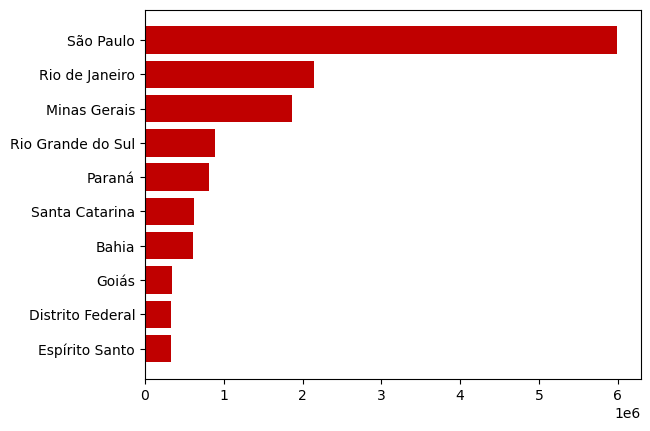

In [93]:
revenue_by_state = oo_oc_oop.groupby('state')['payment_value'].sum().reset_index().sort_values(by='payment_value', ascending = False)
top_revenue_by_state = revenue_by_state.head(10)
plt.barh(top_revenue_by_state['state'],top_revenue_by_state['payment_value'], color = "#C00000")
plt.gca().invert_yaxis() 
plt.show()

### Order by State

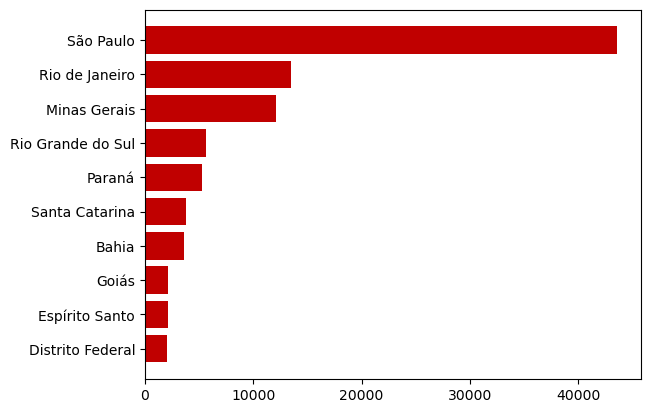

In [94]:
order_by_state = oo_oc_oop.groupby('state')['order_id'].count().reset_index().sort_values(by='order_id', ascending = False).head(10)

plt.barh(order_by_state['state'],order_by_state['order_id'], color = "#C00000")
plt.gca().invert_yaxis() 
plt.show()

### Revenue by State

In [95]:
# oo = 99.441 - oop = 103.886 - oo_oop = 103.886
oo_oop = pd.merge(oo, oop, on='order_id', how='inner')

# oo_oop = 103.886 - oc = 99.441 - oo_oop_oc = 103.886
oo_oop_oc = pd.merge(oo_oop, oc, on='customer_id', how='inner')

# oo_oop_oc = 103.886 - ogg = 19.015 - oo_oop_oc_ogg = 103.599
oo_oop_oc_ogg = pd.merge(oo_oop_oc, ogg, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='inner')

In [96]:
geo_revenue = oo_oop_oc_ogg.groupby('geolocation_zip_code_prefix').agg({'payment_value': 'sum', 'geolocation_lat': 'first', 'geolocation_lng': 'first'}).reset_index()
lat_min, lat_max = -33.75, 5.2641
lon_min, lon_max = -73.9851, -34.7931

c1 = geo_revenue['geolocation_lat'] >= lat_min
c2 = geo_revenue['geolocation_lat'] <= lat_max
c3 = geo_revenue['geolocation_lng'] >= lon_min
c4 = geo_revenue['geolocation_lng'] <= lon_max

geo_revenue = geo_revenue[c1 & c2 & c3 & c4]

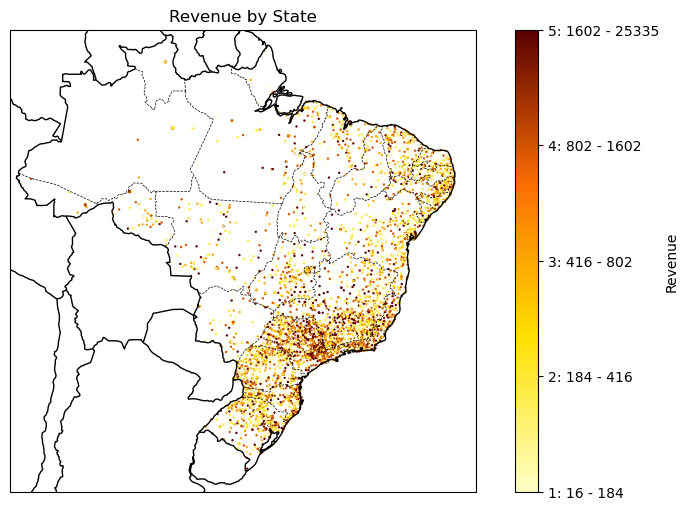

In [126]:
# Define the colors at each end of the color bar
color0 = '#FFFFC5'
color1 = '#FEE000'  
color2 = '#FB6D03'  
color3 = '#580000'

# Create a custom colormap with a smooth gradient between the two colors
colors = [color0, color1, color2, color3]
cmap_custom = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)

# Define the number of categories and colormap
num_categories = 5

# Create a new column with the discretized categories
geo_revenue['category'] = pd.qcut(geo_revenue['payment_value'], q=num_categories, labels=False)

# Define the quantile ranges
quantile_ranges = pd.qcut(geo_revenue['payment_value'], q=num_categories).unique()

# Create a new figure
plt.figure(figsize=(10, 6))

# Create a map using PlateCarree projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Add country borders
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='Black')

# Add coastlines for reference
ax.coastlines(edgecolor='gray')

# Add states and provinces with labels using dashed lines
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

ax.add_feature(states_provinces, edgecolor='black', linestyle='--', linewidth=0.5)

# Scatter plot with markers colored by category
sc = ax.scatter(geo_revenue['geolocation_lng'], geo_revenue['geolocation_lat'], c=geo_revenue['category'],
                cmap=cmap_custom, s=0.5, alpha=1, transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(sc, ticks=range(num_categories), label='Revenue')

# Set colorbar labels to quantile ranges
cbar.ax.set_yticklabels([f'{i+1}: {int(quantile_ranges[i].left)} - {int(quantile_ranges[i].right)}' for i in range(num_categories)])

# Add a title
plt.title('Revenue by State')

# Show the plot
plt.show()

##### The revenue is likely to be concentrated in major urban centers and economically developed regions such as the Southern and Southeastern states, including São Paulo and Rio de Janeiro. These states are home to large urban populations, high internet penetration rates, and a concentration of businesses and retail outlets, all factors that boost e-commerce activity.

##### The Southern states, including Santa Catarina, Rio Grande do Sul, and Paraná, are known for their strong industrial base and relatively higher income levels. Rrevenue from these states may be significant, driven by a tech-savvy population and a culture of online shopping.##### Northeastern states like Amazonas, Pará, and Tocantins may contribute a smaller share of the overall e-commerce revenue compared to the Southern and Southeastern states duee th less developede econom. d##### The central region, parts of the north and all of the west are mostly unprofitable. The reason is very clear because this is the territory of the  Amazon tropical rain forest, which cover 60% of Brazil





### Freight Value by State

In [98]:
# oo = 99.441 - ooi = 112.650 - oo_ooi = 112.650
oo_ooi = pd.merge(oo, ooi, on='order_id', how='inner')

# oo_ooi = 112.650 - oc = 99.441 - oo_ooi_oc = 112.650
oo_ooi_oc = pd.merge(oo_ooi, oc, on='customer_id', how='inner')

# oo_ooi_oc = 112.650 - ogg = 19.015 - oo_oop_oc_ogg = 112.348
oo_ooi_oc_ogg = pd.merge(oo_ooi_oc, ogg, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='inner')

In [99]:
geo_freight_value = oo_ooi_oc_ogg.groupby('geolocation_zip_code_prefix').agg({'freight_value': 'mean', 'geolocation_lat': 'first', 'geolocation_lng': 'first'}).reset_index()
lat_min, lat_max = -33.75, 5.2641
lon_min, lon_max = -73.9851, -34.7931

c1 = geo_freight_value['geolocation_lat'] >= lat_min
c2 = geo_freight_value['geolocation_lat'] <= lat_max
c3 = geo_freight_value['geolocation_lng'] >= lon_min
c4 = geo_freight_value['geolocation_lng'] <= lon_max

geo_freight_value = geo_freight_value[c1 & c2 & c3 & c4]


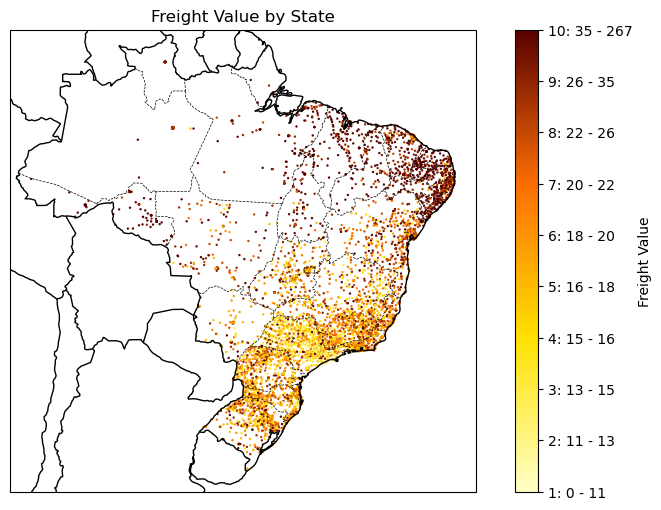

In [100]:
# Define the colors at each end of the color bar
color0 = '#FFFFC5'
color1 = '#FEE000'  
color2 = '#FB6D03'  
color3 = '#580000'

# Create a custom colormap with a smooth gradient between the two colors
colors = [color0, color1, color2, color3]
cmap_custom = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)

# Define the number of categories and colormap
num_categories = 10

# Create a new column with the discretized categories
geo_freight_value['category'] = pd.qcut(geo_freight_value['freight_value'], q=num_categories, labels=False)

# Define the quantile ranges
quantile_ranges = pd.qcut(geo_freight_value['freight_value'], q=num_categories).unique()

# Sort the quantile ranges
quantile_ranges = sorted(quantile_ranges)

# Create a new figure
plt.figure(figsize=(10, 6))

# Create a map using PlateCarree projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Add country borders
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='Black')

# Add coastlines for reference
ax.coastlines(edgecolor='gray')

# Add states and provinces with labels using dashed lines
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

ax.add_feature(states_provinces, edgecolor='black', linestyle='--', linewidth=0.5)

# Scatter plot with markers colored by category
sc = ax.scatter(geo_freight_value['geolocation_lng'], geo_freight_value['geolocation_lat'], c=geo_freight_value['category'],
                cmap=cmap_custom, s=0.5, alpha=1, transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(sc, ticks=range(num_categories), label='Freight Value')

# Set colorbar labels to quantile ranges
cbar.ax.set_yticklabels([f'{i+1}: {int(quantile_ranges[i].left)} - {int(quantile_ranges[i].right)}' for i in range(num_categories)])

# Add a title
plt.title('Freight Value by State')

# Show the plot
plt.show()

##### Coastal states like São Paulo and Rio de Janeiro may benefit from lower freight costs compared to interior regions, thanks to well-established transportation networks and proximity to seaports.
##### Similarly, freight costs in the Southern states, including Santa Catarina, Rio Grande do Sul, and Paraná, may be comparatively lower due to better-developed road and rail networks in these regions.
##### Freight costs in the Northern states of Brazil, such as Amazonas, Pará, and Tocantins, may be relatively higher compared to other regions due to the vast distances and challenges in transportation infrastructure. The reasons may bee limited road connectivity, remote locations, and logistical complexities in the Amazon region can contribute to higher freight expenses.


### Delayed Delivery Day by State

In [ ]:
oo['gap_sec_between_estimate_actual'] = (oo["order_delivered_customer_date"] - oo["order_estimated_delivery_date"]).dt.total_seconds()

In [101]:
oo['delay_day'] = oo['gap_sec_between_estimate_actual']/86400

# oo = 99.441 - oc = 99.441 - oo_ooi = 99.441
oo_oc = pd.merge(oo, oc, on='customer_id', how='inner')

# oo_ooi = 99.441 - ogg = 19.015 - oo_oop_oc_ogg = 99.163
oo_oc_ogg = pd.merge(oo_oc, ogg, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='inner')


In [102]:
geo_delay = oo_oc_ogg.groupby('geolocation_zip_code_prefix').agg({'delay_day': 'mean', 'geolocation_lat': 'first', 'geolocation_lng': 'first'}).reset_index()
lat_min, lat_max = -33.75, 5.2641
lon_min, lon_max = -73.9851, -34.7931

c1 = geo_delay['geolocation_lat'] >= lat_min
c2 = geo_delay['geolocation_lat'] <= lat_max
c3 = geo_delay['geolocation_lng'] >= lon_min
c4 = geo_delay['geolocation_lng'] <= lon_max

geo_delay = geo_delay[c1 & c2 & c3 & c4]

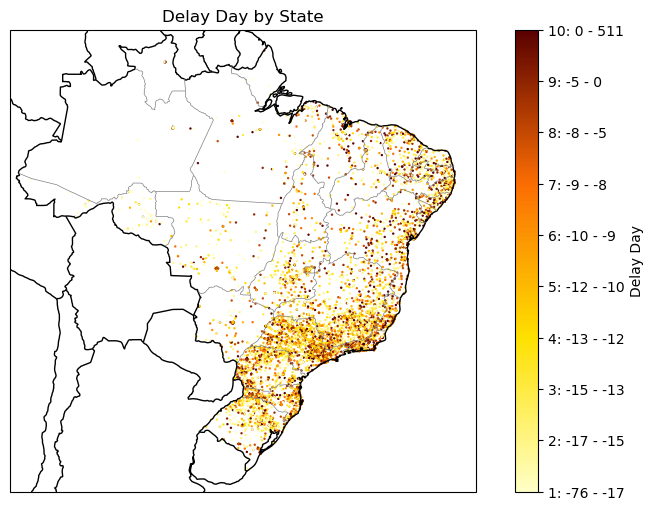

In [103]:
# Define the colors at each end of the color bar
color0 = '#FFFFC5'
color1 = '#FEE000'  
color2 = '#FB6D03'  
color3 = '#580000'

# Create a custom colormap with a smooth gradient between the two colors
colors = [color0, color1, color2, color3]
cmap_custom = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)

# Define the number of categories and colormap
num_categories = 10

# Create a new column with the discretized categories, handling duplicates
geo_delay['category'] = pd.qcut(geo_delay['delay_day'], q=num_categories, labels=False)

# Define the quantile ranges
quantile_ranges = pd.qcut(geo_delay['delay_day'], q=num_categories).unique()

# Sort the quantile ranges
quantile_ranges = sorted(quantile_ranges)

# Create a new figure
plt.figure(figsize=(10, 6))

# Create a map using PlateCarree projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Add country borders
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='Black')

# Add coastlines for reference
ax.coastlines(edgecolor='gray')

# Add states and provinces with labels using dashed lines
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

ax.add_feature(states_provinces, edgecolor='gray', linestyle='-', linewidth=0.5)

# Scatter plot with markers colored by category
sc = ax.scatter(geo_delay['geolocation_lng'], geo_delay['geolocation_lat'], c=geo_delay['category'],
                cmap=cmap_custom, s=0.5, alpha=1, transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(sc, ticks=range(num_categories), label='Delay Day')

# Set colorbar labels to quantile ranges
cbar.ax.set_yticklabels([f'{i+1}: {int(quantile_ranges[i].left)} - {int(quantile_ranges[i].right)}' for i in range(num_categories)])

# Add a title
plt.title('Delay Day by State')

# Show the plot
plt.show()

In [104]:
late_delivery_rate = oo[oo['order_estimated_delivery_date'] < oo['order_delivered_customer_date']].shape[0]/oo.shape[0]*100
late_delivery_rate

9.531279854386018

##### The number of days of late delivery does not seem to be affected by geographical location as the colors representing the number of days of late delivery in different locations do not seem to differ. Another thing worth mentioning is that the late delivery rate seems not to be so insignificant since it only account for less than 10% and the delayed mostly from 5 to 17 days only.

### Delivery Day by State

In [105]:
geo_delivery = oo_oc_ogg.groupby('geolocation_zip_code_prefix').agg({'delivery_time_seconds': 'mean', 'geolocation_lat': 'first', 'geolocation_lng': 'first'}).reset_index()
geo_delivery['delivery_day'] = geo_delivery['delivery_time_seconds']/86400
lat_min, lat_max = -33.75, 5.2641
lon_min, lon_max = -73.9851, -34.7931

c1 = geo_delivery['geolocation_lat'] >= lat_min
c2 = geo_delivery['geolocation_lat'] <= lat_max
c3 = geo_delivery['geolocation_lng'] >= lon_min
c4 = geo_delivery['geolocation_lng'] <= lon_max

geo_delivery = geo_delivery[c1 & c2 & c3 & c4]

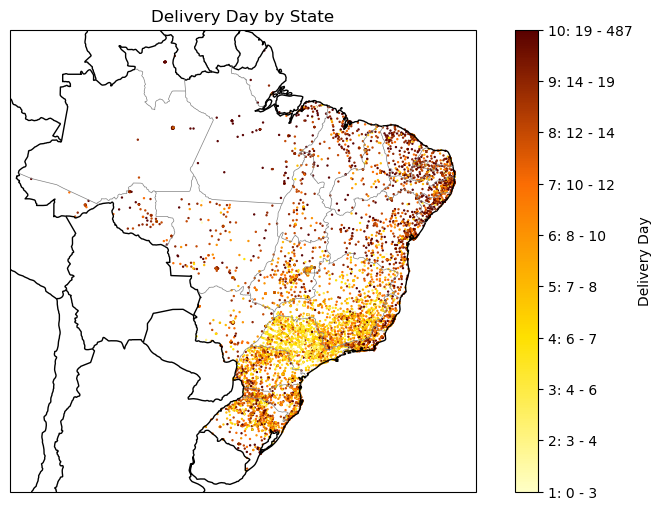

In [125]:
# Define the colors at each end of the color bar
color0 = '#FFFFC5'
color1 = '#FEE000'  
color2 = '#FB6D03'  
color3 = '#580000'

# Create a custom colormap with a smooth gradient between the two colors
colors = [color0, color1, color2, color3]
cmap_custom = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)

# Define the number of categories and colormap
num_categories = 10

# Create a new column with the discretized categories, handling duplicates
geo_delivery['category'] = pd.qcut(geo_delivery['delivery_day'], q=num_categories, labels=False)


# Define the quantile ranges
quantile_ranges = pd.qcut(geo_delivery['delivery_day'], q=num_categories).unique()

# Sort the quantile ranges
quantile_ranges = sorted(quantile_ranges)

# Create a new figure
plt.figure(figsize=(10, 6))

# Create a map using PlateCarree projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Add country borders
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='Black')

# Add coastlines for reference
ax.coastlines(edgecolor='gray')

# Add states and provinces with labels using dashed lines
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

ax.add_feature(states_provinces, edgecolor='gray', linestyle='-', linewidth=0.5)

# Scatter plot with markers colored by category
sc = ax.scatter(geo_delivery['geolocation_lng'], geo_delivery['geolocation_lat'], c=geo_delivery['category'],
                cmap=cmap_custom, s=0.5, alpha=1, transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(sc, ticks=range(num_categories), label='Delivery Day')

# Set colorbar labels to quantile ranges
cbar.ax.set_yticklabels([f'{i+1}: {int(quantile_ranges[i].left)} - {int(quantile_ranges[i].right)}' for i in range(num_categories)])

# Add a title
plt.title('Delivery Day by State')

# Show the plot
plt.show()

##### Similar to to aboved data, Brazil's e-commerce activity is primarily concentrated in the southern and southeastern regions, notably São Paulo, Rio de Janeiro, and Rio Grande do Sul. These locations have large metropolitan centers, well-developed transportation networks, and a concentration of e-commerce fulfillment centers, which account for a significant share of e-commerce deliveries.
##### In contrast, the northern and northeastern regions of Brazil, including states like Amazonas, Pará, and Bahia, may face logistical challenges due to the vast Amazon rainforest and less developed infrastructure.


## 3.3. Which Categories are most sold

### Most Ordered Category

In [107]:
# oo = 99.441 - ooi = 112.650 - oo_ooi = 112.650
oo_ooi = pd.merge(oo, ooi, on='order_id', how='inner')

# oo_ooi = 112.650 - oc = 99.441 - oo_ooi_op = 112.632
oo_ooi_op = pd.merge(oo_ooi, op, on='product_id', how='inner')

# oo_ooi_op = 112.632 - oor = 99.224 - oo_ooi_op_oor = 112.354
oo_ooi_op_oor = pd.merge(oo_ooi_op, oor, on='order_id', how='inner')

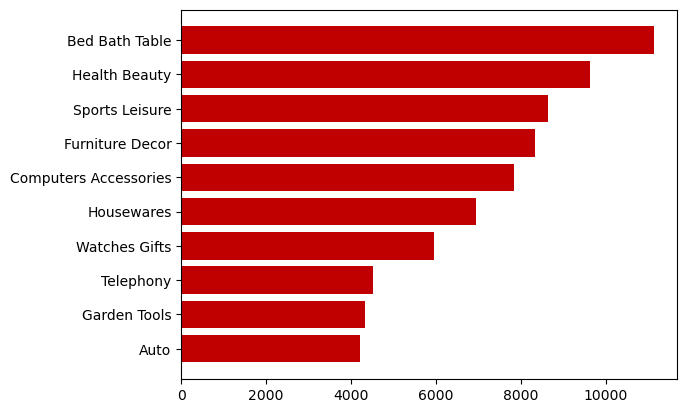

In [109]:
highest_review_score_category = oo_ooi_op_oor.groupby('product_category_name_english').agg({'review_score': 'mean','order_id':'count'}).reset_index().sort_values(by='order_id', ascending = False).head(10)
highest_review_score_category
plt.barh(highest_review_score_category['product_category_name_english'],highest_review_score_category['order_id'], color = "#C00000")
plt.gca().invert_yaxis() 
plt.show()

### Review Score Distribution

In [263]:
review_score_distribution = oor['review_score'].value_counts().reset_index()
review_score_distribution

,review_score,count
0,5,57328
1,4,19142
2,1,11424
3,3,8179
4,2,3151


### Review Score of Most Order Categories

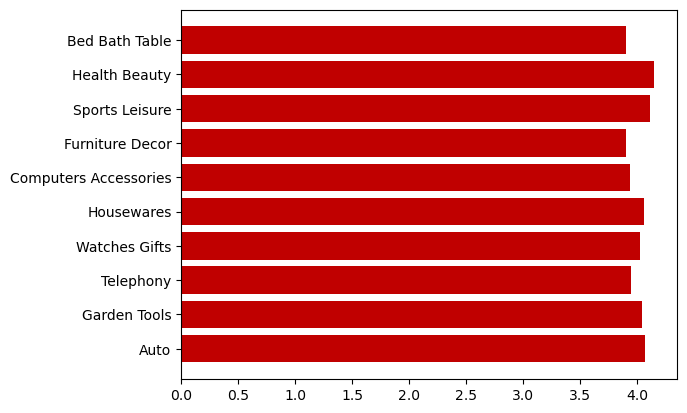

In [295]:
plt.barh(highest_review_score_category['product_category_name_english'],highest_review_score_category['review_score'], color = "#C00000")
plt.gca().invert_yaxis() 
plt.show()

### Total Orders and Average Review Scores by Category

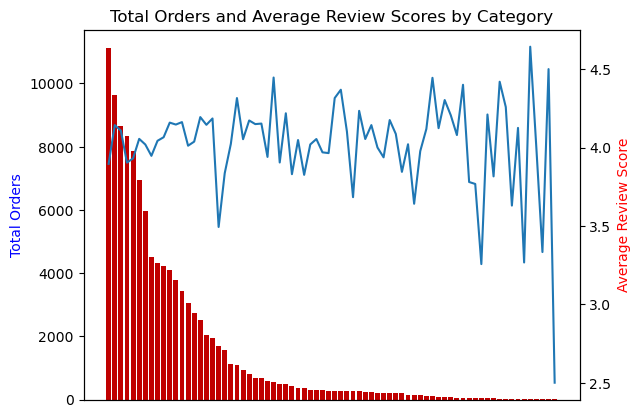

In [300]:
highest_review_score_category = oo_ooi_op_oor.groupby('product_category_name_english').agg({'review_score': 'mean','order_id':'count'}).reset_index().sort_values(by='order_id', ascending = False)

fig, ax1 = plt.subplots()

# Create bars for total orders on the left y-axis
ax1.bar(highest_review_score_category['product_category_name_english'], highest_review_score_category['order_id'], color = "#C00000")
ax1.set_ylabel('Total Orders', color='b')

# Create a second y-axis for the average review scores on the right side
ax2 = ax1.twinx()
ax2.plot(highest_review_score_category['product_category_name_english'], highest_review_score_category['review_score'])
ax2.set_ylabel('Average Review Score', color='r')

plt.xticks([])

plt.title('Total Orders and Average Review Scores by Category')
plt.show()

##### We can observe that products with a higher number of orders have an average score of roughly 4, which is consistent. Products with minimal total orders, on the other hand, frequently have highly variable rating scores, ranging from close to 5 to below 3.
##### The reason behind this may because popular products attract a broader diversity of customers and perspectives, resulting in average review scores of 4. Less ordered products obtain higher scores, frequently close to 5 or 3, as a result of feedback from a small but satisfied or disapointed consumer base.


## 3.4. What is the most used Payment Method

### Payment Method Distribution

In [301]:
payment_type_distribution = oop['payment_type'].value_counts().reset_index()
payment_type_distribution

,payment_type,count
0,Credit Card,76795
1,Boleto,19784
2,Voucher,5775
3,Debit Card,1529
4,Not Defined,3


### Number of Payment Type by Year

In [121]:
payment_method_by_time = oo_oop_oc_ogg[['order_purchase_timestamp','payment_type']].copy()
payment_method_by_time['Year'] = payment_method_by_time['order_purchase_timestamp'].dt.year
payment_method_by_time['Month'] = payment_method_by_time['order_purchase_timestamp'].dt.month
payment_method_by_time['Month-Year'] = payment_method_by_time['Year'].astype(str) + '-' + payment_method_by_time['Month'].astype(str)  

payment_method_by_time = payment_method_by_time.groupby(['Year','Month','payment_type']).size().reset_index(name='payment_count')
payment_method_by_time['Month-Year'] = payment_method_by_time['Year'].astype(str) + '-' + payment_method_by_time['Month'].astype(str)  

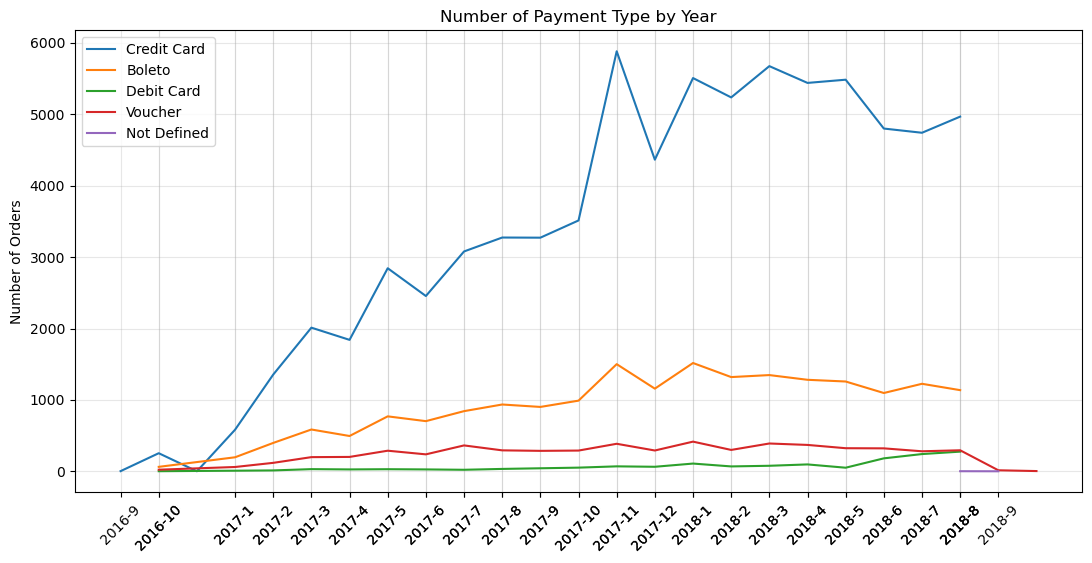

In [124]:
plt.figure(figsize=(13, 6))
for x in payment_method_by_time['payment_type'].unique():
    data_year = payment_method_by_time[payment_method_by_time['payment_type'] == x]
    plt.plot(data_year['Month-Year'], data_year['payment_count'], label=f'{x}')
plt.ylabel('Number of Orders')
plt.title('Number of Payment Type by Year')
plt.grid(True, alpha = 0.3)
plt.xticks(range(1, 13))
plt.legend(loc='upper left')
plt.xticks( payment_method_by_time['Month-Year'][::2], rotation=45)


plt.show()

##### Credit cards are the preferred payment method for e-commerce due to benefits like installment payments and consumer protections, while boleto bancário, vouchers, and debit cards are less commonly used. The reason may because credit cards offer convenience, rewards, and accessibility, making them a standard choice. Challenges with other methods include the cash-based nature of boleto, limited use of vouchers, and the lack of benefits with debit cards.

## 3.5. How Seller location affect Revenue

### City with most Seller

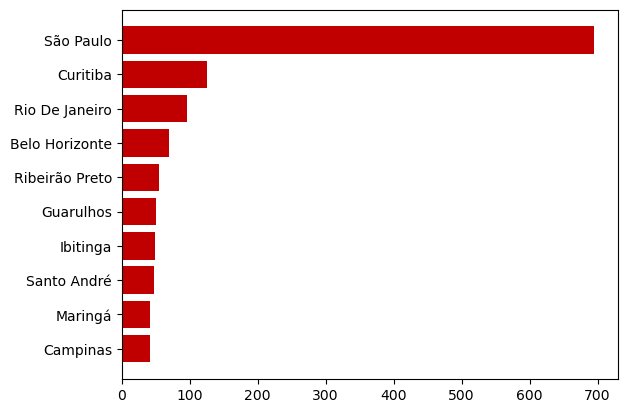

In [351]:
city_with_most_seller = os['city'].value_counts().head(10).reset_index().sort_values(by='count', ascending = False).head(10)
plt.barh(city_with_most_seller['city'],city_with_most_seller['count'], color = "#C00000")
plt.gca().invert_yaxis() 
plt.show()

### Number of Seller by Category

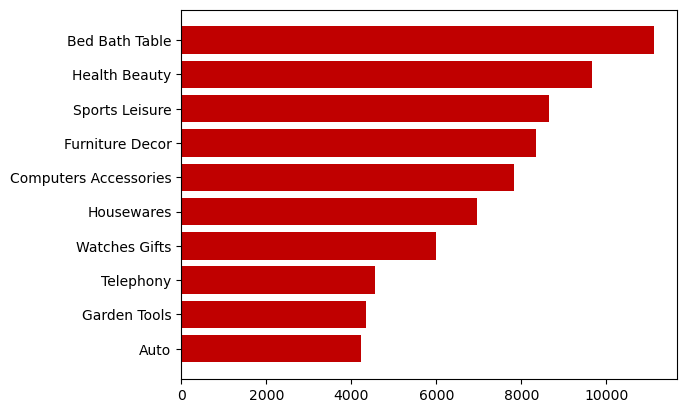

In [352]:
seller_by_category = op_ooi_os.groupby('product_category_name_english')['seller_id'].count().reset_index().sort_values(by='seller_id', ascending = False).head(10)

plt.barh(seller_by_category['product_category_name_english'],seller_by_category['seller_id'], color = "#C00000")
plt.gca().invert_yaxis() 
plt.show()

### Number of Seller by State

In [117]:
# oo = 99.441 - ooi = 112.650 - oo_ooi = 112.650
oo_ooi = pd.merge(oo, ooi, on='order_id', how='inner')

# oo_ooi = 112.650 - os = 3.095 - oo_ooi_os = 112.650
oo_ooi_os = pd.merge(oo_ooi, os, on='seller_id', how='inner')

# oo_ooi_os = 112.650 - ogg = 19.015 - oo_oop_oc_ogg = 112.397
oo_ooi_os_ogg = pd.merge(oo_ooi_os, ogg, left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='inner')

In [118]:
geo_seller= oo_ooi_os_ogg.groupby('geolocation_zip_code_prefix').agg({'seller_id': 'count', 'geolocation_lat': 'first', 'geolocation_lng': 'first'}).reset_index()
lat_min, lat_max = -33.75, 5.2641
lon_min, lon_max = -73.9851, -34.7931

c1 = geo_seller['geolocation_lat'] >= lat_min
c2 = geo_seller['geolocation_lat'] <= lat_max
c3 = geo_seller['geolocation_lng'] >= lon_min
c4 = geo_seller['geolocation_lng'] <= lon_max

geo_seller = geo_seller[c1 & c2 & c3 & c4]

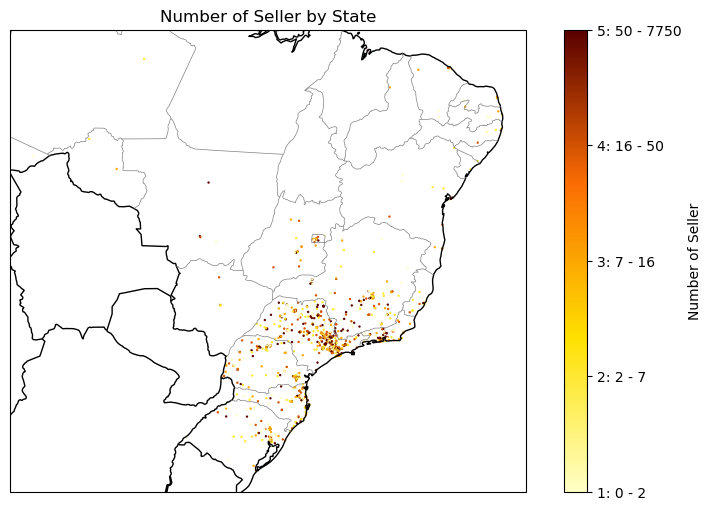

In [119]:
# Define the colors at each end of the color bar
color0 = '#FFFFC5'
color1 = '#FEE000'  
color2 = '#FB6D03'  
color3 = '#580000'

# Create a custom colormap with a smooth gradient between the two colors
colors = [color0, color1, color2, color3]
cmap_custom = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)

# Define the number of categories and colormap
num_categories = 5

# Create a new column with the discretized categories, handling duplicates
geo_seller['category'] = pd.qcut(geo_seller['seller_id'], q=num_categories, labels=False)

# Define the quantile ranges
quantile_ranges = pd.qcut(geo_seller['seller_id'], q=num_categories).unique()

# Sort the quantile ranges
quantile_ranges = sorted(quantile_ranges)

# Create a new figure
plt.figure(figsize=(10, 6))

# Create a map using PlateCarree projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Add country borders
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='Black')

# Add coastlines for reference
ax.coastlines(edgecolor='gray')

# Add states and provinces with labels using dashed lines
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

ax.add_feature(states_provinces, edgecolor='gray', linestyle='-', linewidth=0.5)

# Scatter plot with markers colored by category
sc = ax.scatter(geo_seller['geolocation_lng'], geo_seller['geolocation_lat'], c=geo_seller['category'],
                cmap=cmap_custom, s=0.5, alpha=1, transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(sc, ticks=range(num_categories), label='Number of Seller')

# Set colorbar labels to quantile ranges
cbar.ax.set_yticklabels([f'{i+1}: {int(quantile_ranges[i].left)} - {int(quantile_ranges[i].right)}' for i in range(num_categories)])

# Add a title
plt.title('Number of Seller by State')

# Show the plot
plt.show()

##### Most sellers are concentrated in the southeastern states, which explains why freight prices here are much cheaper than other regions, revenue here is also higher and delivery times are shorter.

## 3.6. How Time affect Customer's purchasing decision

### Order by Time in Day

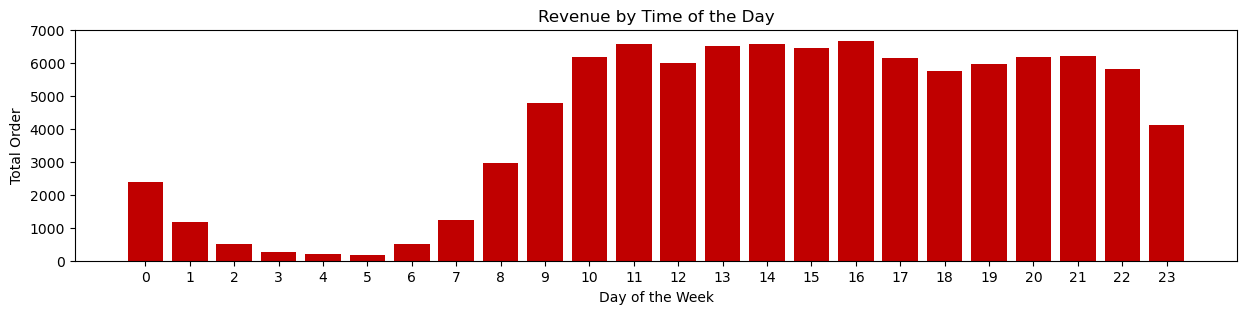

In [115]:
oo1 = oo.copy()
oo1['hour'] = oo1['order_purchase_timestamp'].dt.hour

order_by_time = oo1['hour'].value_counts().reset_index().sort_values('hour', ascending=True)

plt.figure(figsize=(15, 3))
plt.bar(order_by_time['hour'],order_by_time['count'], color = "#C00000")
plt.xlabel('Day of the Week')
plt.ylabel('Total Order')
plt.title('Revenue by Time of the Day')
plt.xticks(order_by_time['hour'])
plt.show()

##### People tend to buy online products between 11am and 4pm.
##### The reason may because 11 am and 4 pm coincide with typical work breaks, such as mid-morning and mid-afternoon pauses, when individuals may have time to browse and make online purchases. Besides, 4pm aligns with the end of the workday for many, when individuals might be commuting or settling back home, providing an opportunity for online shopping.

### Revenue by Day in Week

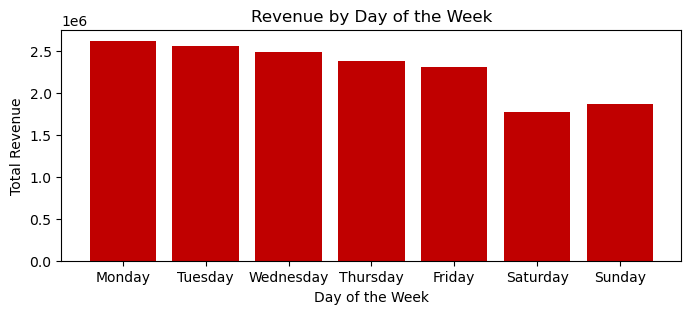

In [463]:
revenue_per_day = oo_oop[['order_purchase_timestamp','payment_value']].copy()
revenue_per_day['Day_of_Week'] = revenue_per_day['order_purchase_timestamp'].dt.day_name()

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
revenue_per_day['Day_of_Week'] = pd.Categorical(revenue_per_day['Day_of_Week'], categories=days_order, ordered=True)

revenue_per_day = revenue_per_day.groupby('Day_of_Week', observed=False)['payment_value'].sum()

plt.figure(figsize=(8, 3))
plt.bar(revenue_per_day.index, revenue_per_day.values, color = "#C00000")
plt.xlabel('Day of the Week')
plt.ylabel('Total Revenue')
plt.title('Revenue by Day of the Week')
plt.show()

##### People tend to buy more on Mondays and less on Saturdays.
##### For Monday, it's the time after the weekend, people often return to work with a refreshed mindset, potentially leading to increased online shopping as they plan purchases for the week ahead. Besides, many retailers launch new products or promotions at the beginning of the week, which can drive higher sales on Mondays.
##### On Saturday, people might be engaged in outdoor activities, social events, or family time during the weekend, leading to less online shopping compared to weekdays when work routines are in place.

## 3.7. How Olist grows over years

### Revenue by Time

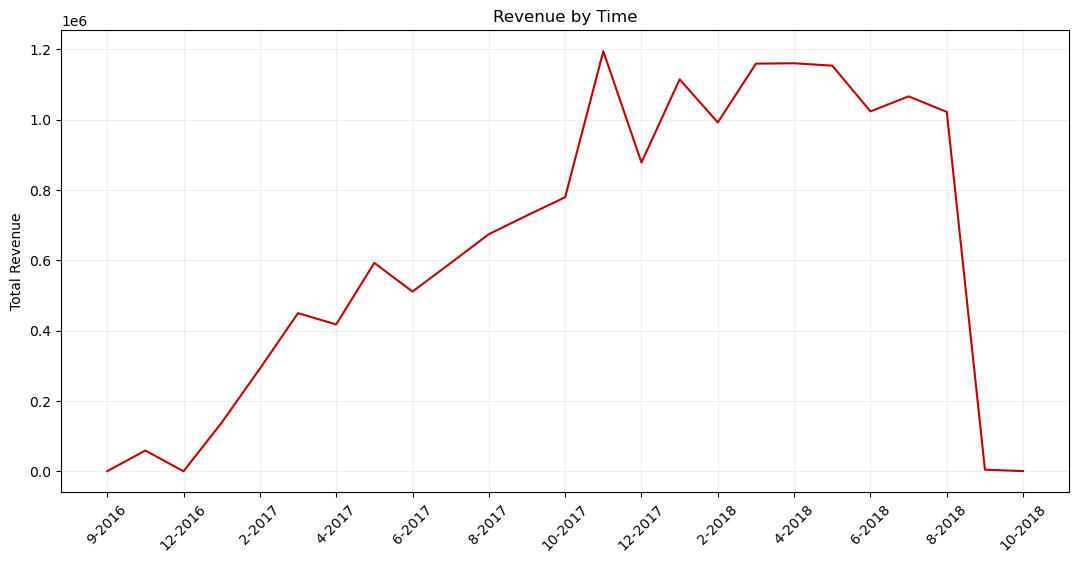

In [113]:
revenue_by_time = oo_oop[['order_purchase_timestamp','payment_value']].copy()
revenue_by_time['Year'] = revenue_by_time['order_purchase_timestamp'].dt.year
revenue_by_time['Month'] = revenue_by_time['order_purchase_timestamp'].dt.month

revenue_by_time = revenue_by_time.groupby(['Year','Month'])['payment_value'].sum().reset_index(name='Total Revenue')
revenue_by_time['Month-Year'] = revenue_by_time['Month'].astype(str) + '-' + revenue_by_time['Year'].astype(str)

plt.figure(figsize=(13, 6))
plt.plot(revenue_by_time['Month-Year'], revenue_by_time['Total Revenue'], color = "#C00000")
plt.ylabel('Total Revenue')
plt.title('Revenue by Time')
plt.grid(True, alpha = 0.2)
plt.xticks(revenue_by_time.index[::2], revenue_by_time['Month-Year'][::2], rotation=45)
plt.show()

### Number of Order by Time

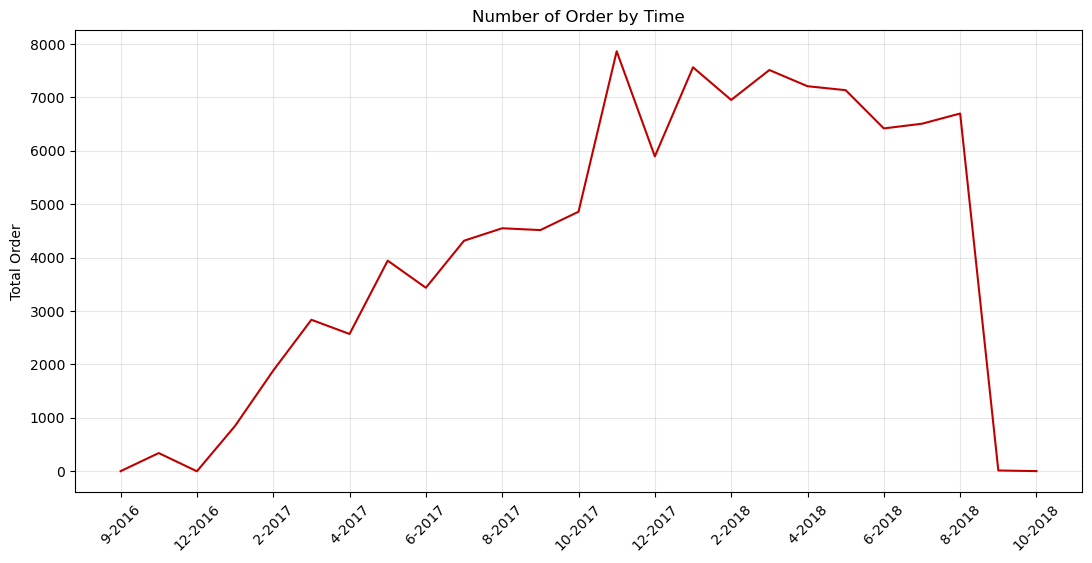

In [111]:
order_by_time = oo_oop[['order_purchase_timestamp','order_id']].copy()
order_by_time['Year'] = order_by_time['order_purchase_timestamp'].dt.year
order_by_time['Month'] = order_by_time['order_purchase_timestamp'].dt.month

order_by_time = order_by_time.groupby(['Year','Month'])['order_id'].count().reset_index(name='Total Order')
order_by_time['Month-Year'] = order_by_time['Month'].astype(str) + '-' + order_by_time['Year'].astype(str)

plt.figure(figsize=(13, 6))
plt.plot(order_by_time['Month-Year'], order_by_time['Total Order'], color = "#C00000")
plt.ylabel('Total Order')
plt.title('Number of Order by Time')
plt.grid(True, alpha = 0.3)
plt.xticks(order_by_time.index[::2], order_by_time['Month-Year'][::2], rotation=45)
plt.show()

### Order Status Distribution

In [81]:
order_status_dstribution = oo['order_status'].value_counts().reset_index()
order_status_dstribution

,order_status,count
0,delivered,96478
1,shipped,1107
2,canceled,625
3,unavailable,609
4,invoiced,314
5,processing,301
6,created,5
7,approved,2


# Key Insights

##### Economically developed regions such as the Southern and Southeastern states, including São Paulo and Rio de Janeiro, are home to large urban populations, high internet penetration rates, and a concentration of businesses and retail outlets, all factors that boost e-commerce activity. As the result, they have outstanding revenue, shortest delivery time and lowest freight value

##### The Southern states, including Santa Catarina, Rio Grande do Sul, and Paraná, are known for their strong industrial base and relatively higher income levels. Rrevenue from these states may be significant, delivery time is also relatively short and freight value is not so high thanks to the proximity to major ports and industrial areas that help reduce transportation costs for businesses operating in these states.

##### Northeastern states like Amazonas, Pará, and Tocantins may contribute a smaller share of the overall e-commerce revenue compared to the Southern and Southeastern states duee th less developede economy. Factors like limited road connectivity, remote locations, and logistical complexities in the Amazon region can contribute to higher freight expenses and delivery day.

##### The central region, parts of the north and all of the west are mostly unprofitable. The reason is very clear because this is the territory of the Amazon tropical rain forest, which cover 60% of Brazil

##### Products with high order volumes tend to maintain an average score of around 4, reflecting diverse customer perspectives. Conversely, less popular items exhibit more variable ratings, often ranging from near-perfect to low scores due to feedback from a smaller, yet more polarized, customer base.

##### Credit cards are the preferred payment method, while boleto bancário, vouchers, and debit cards are less commonly used. The reason may because credit cards offer convenience, rewards, and accessibility, making them a standard choice. Challenges with other methods include the cash-based nature of boleto, limited use of vouchers, and the lack of benefits with debit cards.

##### Online purchases peak between 11 am and 4 pm, likely due to these times coinciding with common work breaks and the end of the workday. Individuals utilize these periods to browse and purchase products, making the most of available downtime.

#####  Mondays see higher online shopping activity as people return to work, planning purchases for the week ahead and taking advantage of new promotions. In contrast, lower online shopping on Saturdays is due to people engaging in weekend activities and social events, prioritizing leisure over making online purchases..